In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np 
import warnings
import optuna
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from data_downloader import DataDownloader, ClimateDataCleaner, EconomicDataCleaner
from var_model import ClimateVAR
from sdice_model import SimplifiedDICE
from portfolio import PortfolioOptimizer

In [2]:
# Instancia para limpiar y procesar los datos climáticos
climate_cleaner = ClimateDataCleaner('Data/Temperature.csv', 'Data/Drought_Severity.csv', 'Data/CO2_Emissions.xlsx')
climate_data = climate_cleaner.clean_and_prepare_data()

# Instancia para limpiar y procesar los datos climáticos
economic_cleaner = EconomicDataCleaner('Data/GDP.csv', 'Data/TB3MS.csv', 'Data/CPI.csv')
economic_data = economic_cleaner.clean_and_prepare_data()

# Descarga los datos financieros
downloader = DataDownloader()
assets = ['AAPL', 'IBM', 'TSLA', 'GOOG', 'NVDA', 'NEE', 'FSLR', 'VWDRY', 'BEP'] 
benchmark = '^GSPC'  
start_date = '2014-11-01'
end_date = '2024-05-31'
rf = .065

asset_prices, benchmark_prices = downloader.download_data(start_date=start_date, 
                                                          end_date=end_date, 
                                                          assets=assets, 
                                                          benchmark=benchmark)

all_data = pd.merge(pd.merge(asset_prices, climate_data, on='Date'), economic_data, on='Date').iloc[:-1]
all_data.drop('Date', axis=1, inplace=True)

[*********************100%%**********************]  9 of 9 completed
[*********************100%%**********************]  1 of 1 completed


In [3]:
# Definir la función objetivo para Optuna
def objective(trial):
    # Elige el número de retardos entre 1 y 10
    maxlags = trial.suggest_int('maxlags', 1, 10)

    # Ajustar el modelo VAR con el número de retardos sugerido
    var_model = ClimateVAR(all_data)
    var_results = var_model.fit(maxlags=maxlags)

    # Realizar predicciones con el número de retardos sugerido
    predicted = var_model.predict(var_results, lags=maxlags, end=100)

    # Definir los valores reales (esto es solo un ejemplo, debes usar tus valores reales)
    actual = all_data[maxlags:100]  # Ajusta según la longitud de tus datos

    # Asegurarse de que predicted y actual tengan la misma longitud
    min_len = min(len(predicted), len(actual))
    predicted = predicted[:min_len]
    actual = actual[:min_len]

    # Calcular el error de predicción (RMSE)
    rmse = np.sqrt(mean_squared_error(actual, predicted))

    return rmse

# Crear el estudio de Optuna para minimizar el RMSE
study = optuna.create_study(direction='minimize')

# Ejecutar la optimización
study.optimize(objective, n_trials=100)

# Imprimir el número óptimo de retardos
print(f'Número óptimo de retardos: {study.best_trial.params["maxlags"]}')
print(f'RMSE óptimo: {study.best_value}')

# Ajustar el modelo VAR con el número óptimo de retardos
optimal_maxlags = study.best_trial.params["maxlags"]
var_model = ClimateVAR(all_data)
var_results = var_model.fit(maxlags=optimal_maxlags)

# Realizar predicción futura con el número óptimo de retardos
predict = var_model.predict(var_results, lags=optimal_maxlags, end=100)

# Imprimir los valores predichos
print("Valores predichos:")
print(predict)

[I 2024-09-20 23:58:42,684] A new study created in memory with name: no-name-4e3c9bce-4b09-4fdc-90dd-ef2be5e249e1
[I 2024-09-20 23:58:42,712] Trial 0 finished with value: 35.123761133444745 and parameters: {'maxlags': 4}. Best is trial 0 with value: 35.123761133444745.
[I 2024-09-20 23:58:42,714] Trial 1 finished with value: 42.67022805905161 and parameters: {'maxlags': 3}. Best is trial 0 with value: 35.123761133444745.
[I 2024-09-20 23:58:42,725] Trial 2 finished with value: 25.97833963657198 and parameters: {'maxlags': 5}. Best is trial 2 with value: 25.97833963657198.
[I 2024-09-20 23:58:42,737] Trial 3 finished with value: 3.447508726110889e-09 and parameters: {'maxlags': 9}. Best is trial 3 with value: 3.447508726110889e-09.
[I 2024-09-20 23:58:42,739] Trial 4 finished with value: 62.85548277627491 and parameters: {'maxlags': 1}. Best is trial 3 with value: 3.447508726110889e-09.
[I 2024-09-20 23:58:42,742] Trial 5 finished with value: 35.123761133444745 and parameters: {'maxlags

Número óptimo de retardos: 9
RMSE óptimo: 3.447508726110889e-09
Valores predichos:
[[-2.18162962e-02 -2.86217494e-02 -1.06396324e-01 ...  1.84016260e+04
   3.00000000e-02  2.38034000e+02]
 [ 8.34091917e-02 -4.03785222e-02  3.34970753e-01 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 [-5.80447204e-03 -3.24407248e-02 -9.81253508e-03 ...  1.84351370e+04
   2.00000000e-02  2.37733000e+02]
 ...
 [ 2.31830905e-02 -9.24476064e-02 -4.76351713e-02 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 1.18648750e-01  2.06355232e-01  2.85916996e-01 ...  2.68136010e+04
   4.54000000e+00  3.00356000e+02]
 [ 2.89871670e-02 -1.61853981e-02 -1.60551716e-01 ...  2.70630120e+04
   4.92000000e+00  3.03032000e+02]]


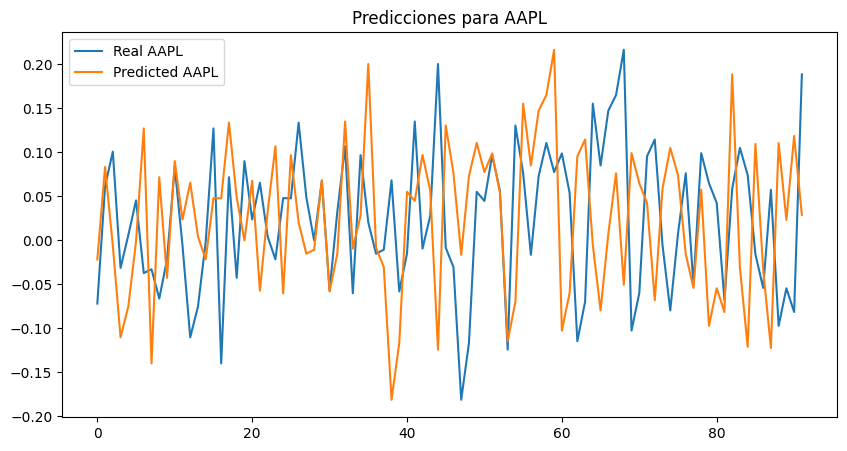

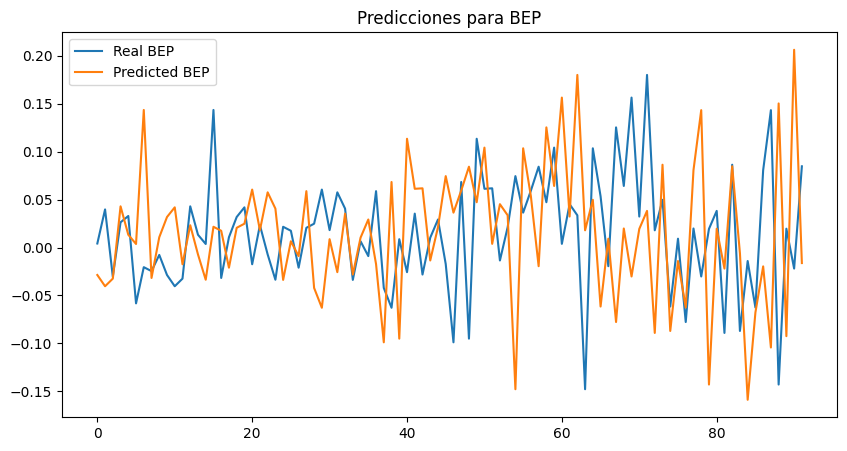

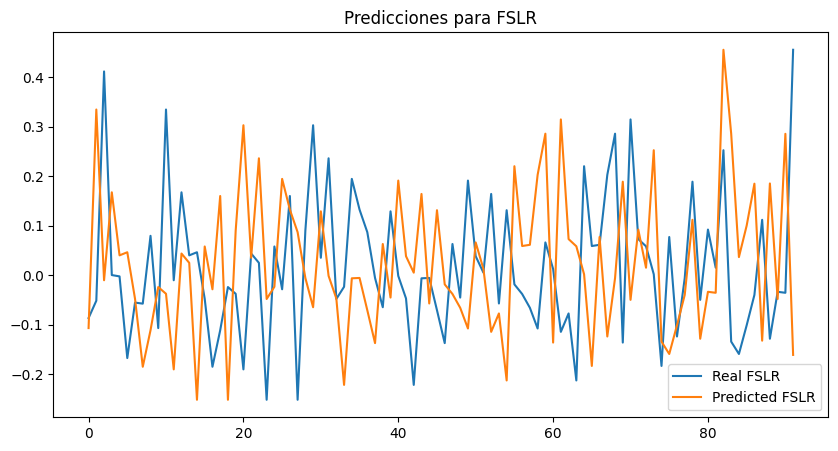

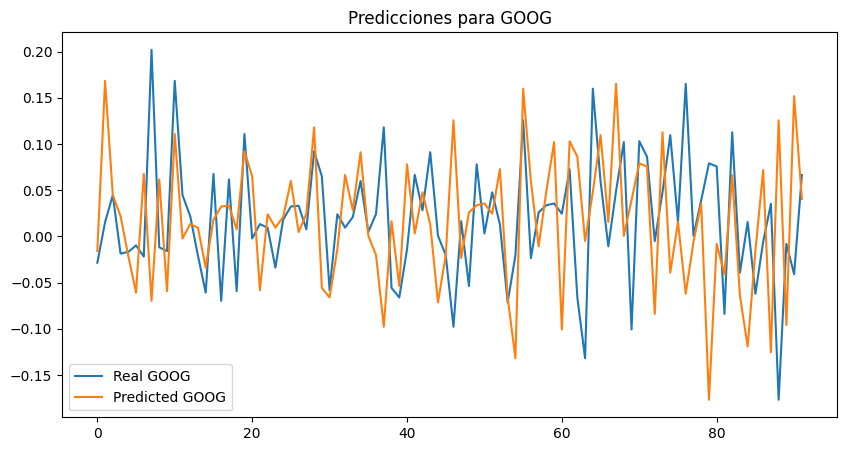

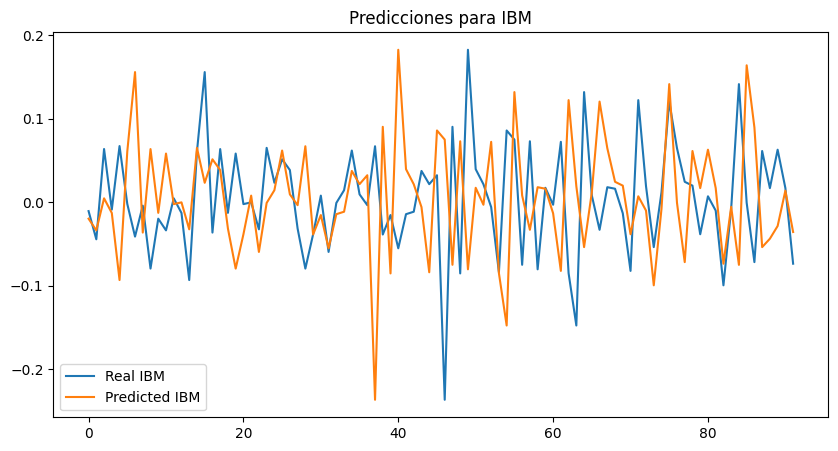

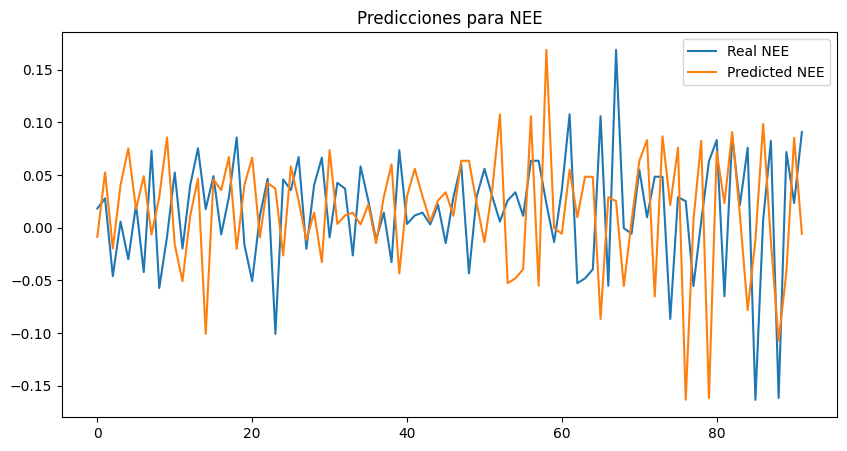

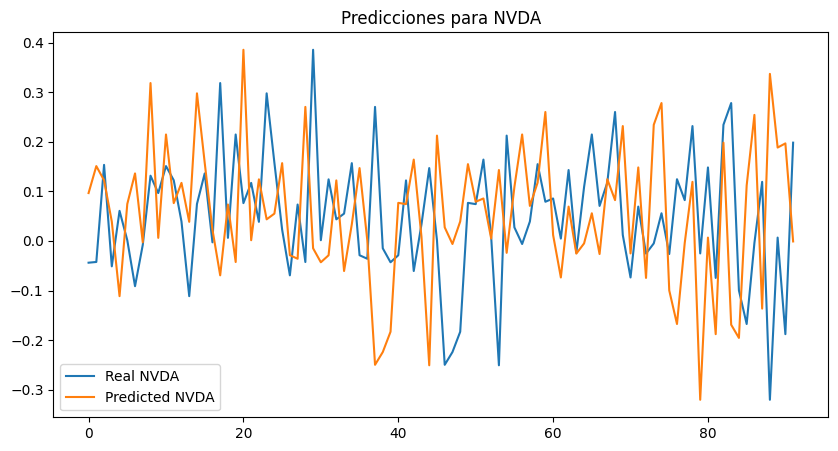

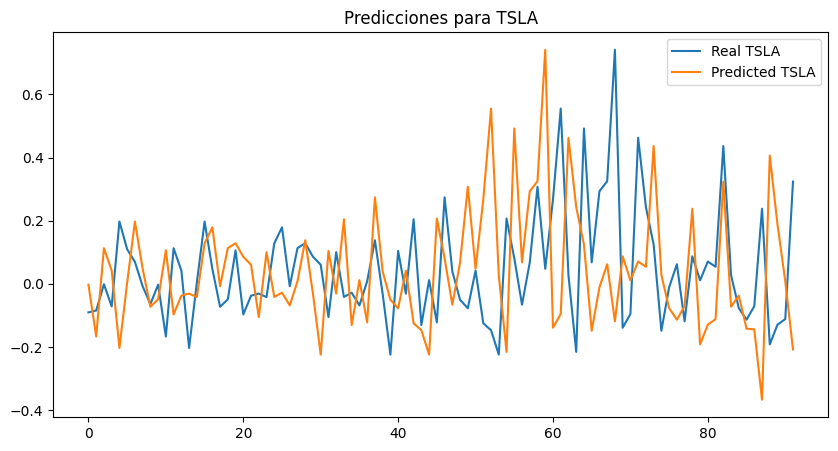

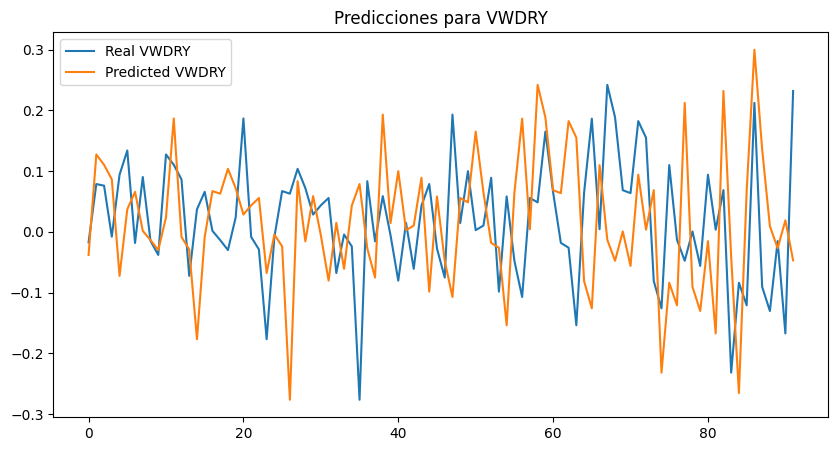

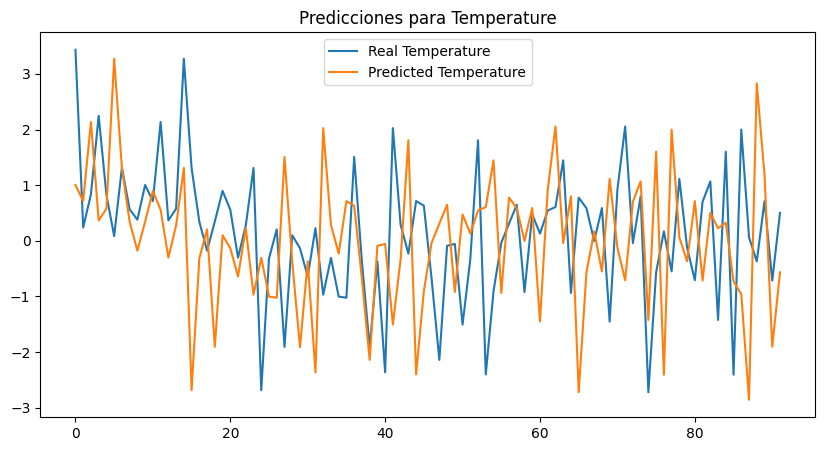

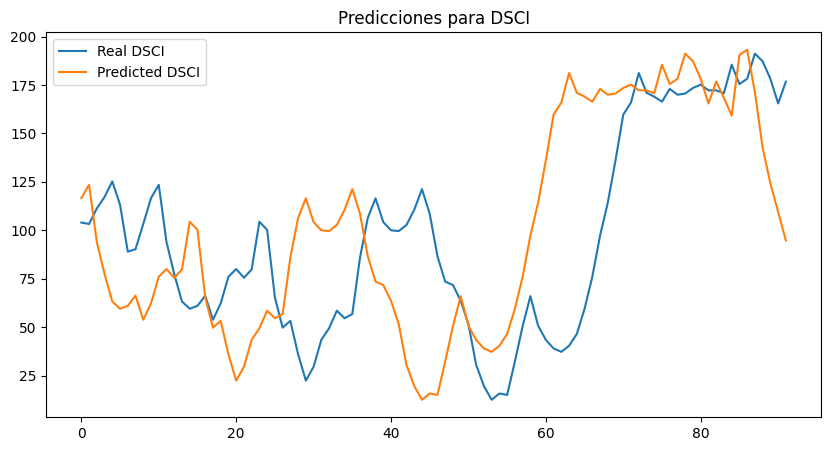

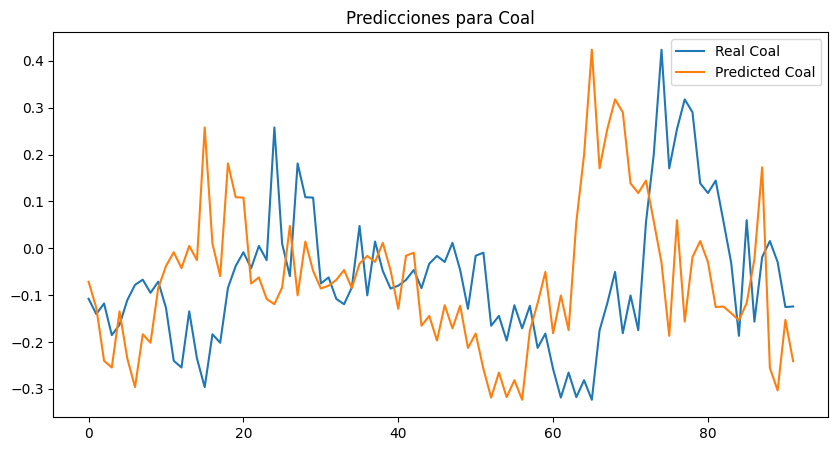

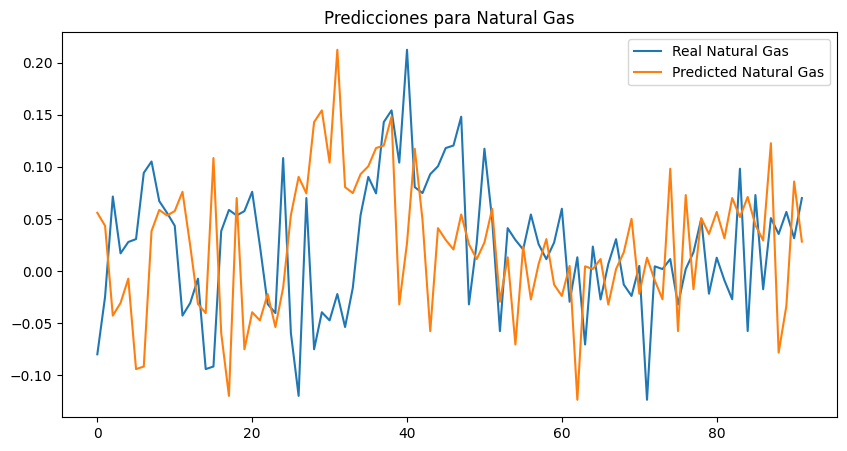

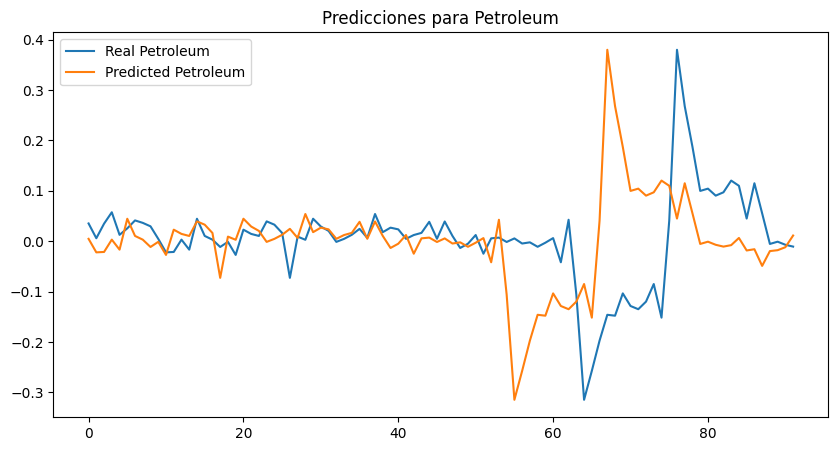

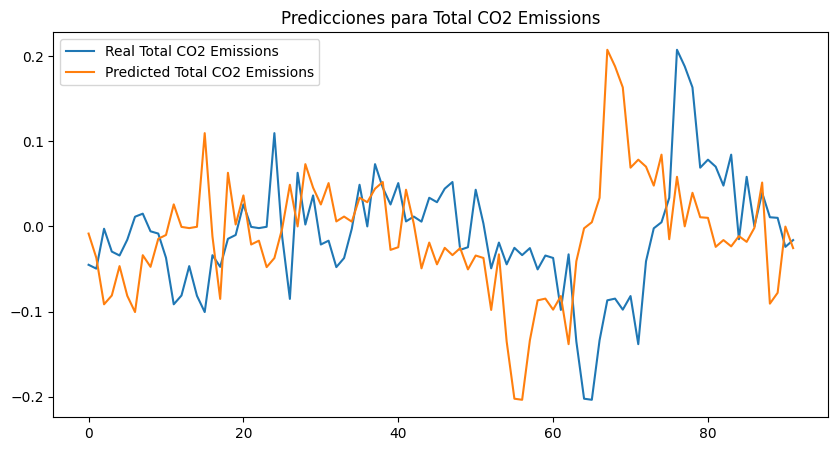

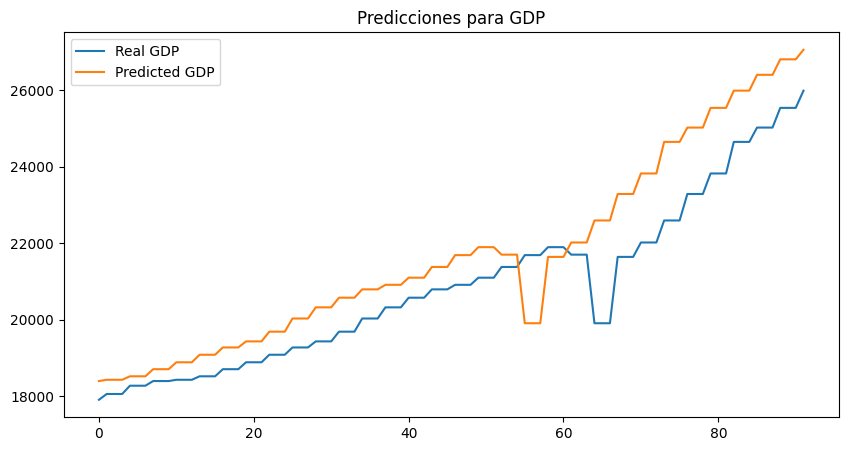

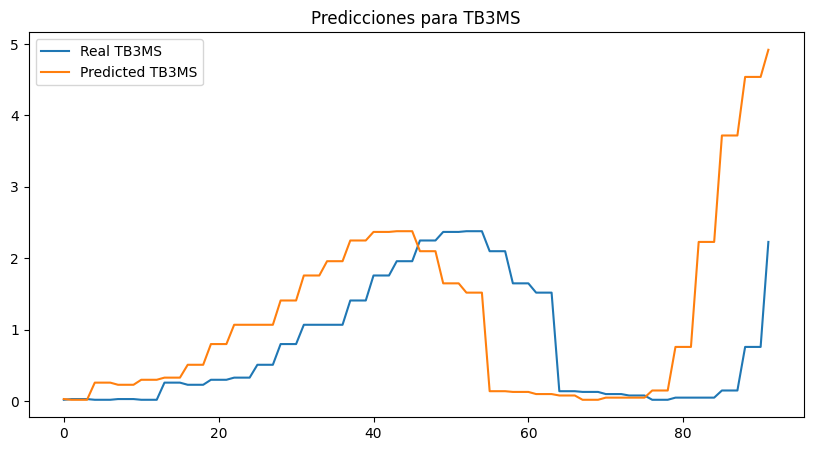

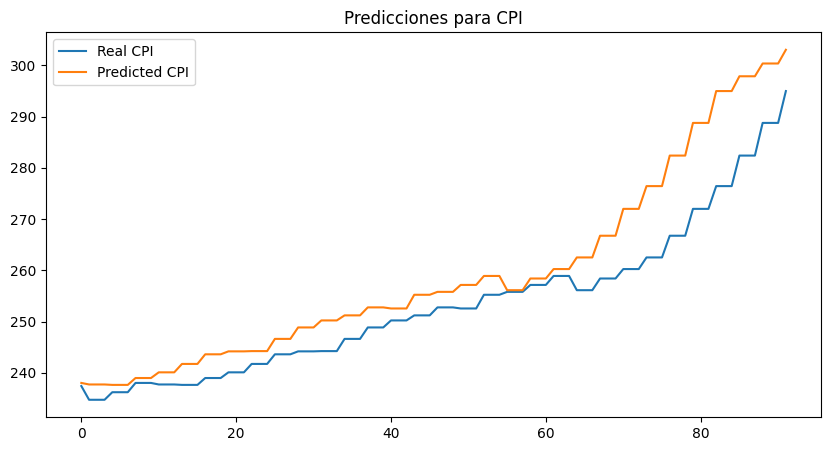

In [4]:
# Graficar las predicciones versus los datos originales
for i, column in enumerate(all_data.columns):
    plt.figure(figsize=(10, 5))
    plt.plot(all_data.index[:len(predict)], all_data.iloc[:len(predict), i], label=f"Real {column}")
    plt.plot(all_data.index[:len(predict)], predict[:, i], label=f"Predicted {column}")
    plt.title(f"Predicciones para {column}")
    plt.legend()
    plt.show()

Escenario Optimista:


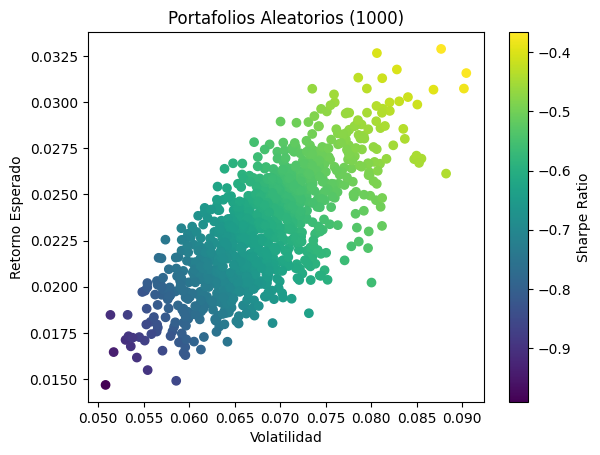

Escenario Pesimista:


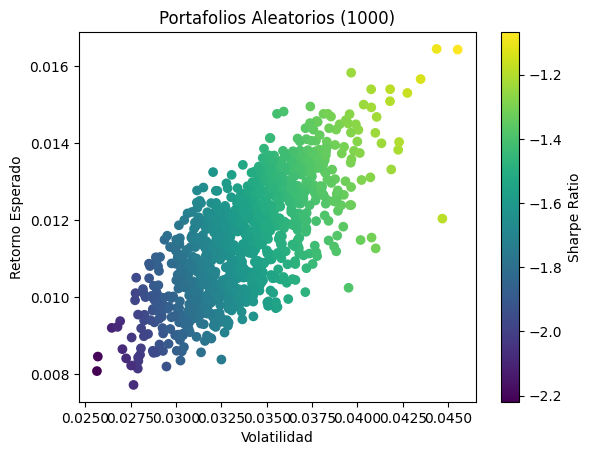

In [11]:
# Crear dos escenarios: optimista y pesimista
def create_optimistic_and_pessimistic_scenarios(asset_returns):
    """
    Crea dos escenarios ajustando los retornos históricos:
    - Optimista: Usa los retornos históricos normales.
    - Pesimista: Reduce los retornos en un factor pesimista.
    
    :param asset_returns: Retornos históricos de los activos.
    :return: Retornos ajustados para escenarios optimistas y pesimistas.
    """
    # Filtrar solo columnas numéricas
    numeric_returns = asset_returns.select_dtypes(include=[np.number])
    
    # Escenario optimista: usar los retornos históricos
    optimistic_returns = numeric_returns.copy()
    
    # Escenario pesimista: reducir los retornos, solo se aplican a los valores numéricos
    pessimistic_returns = numeric_returns.copy()
    pessimistic_returns.loc[:, :] = pessimistic_returns * 0.5  # Operación solo sobre los valores
    
    return optimistic_returns, pessimistic_returns



# Escenarios
optimistic_returns, pessimistic_returns = create_optimistic_and_pessimistic_scenarios(asset_prices)


# Instancia para el escenario optimista
optimizer_optimistic = PortfolioOptimizer(optimistic_returns, rf)

# Instancia para el escenario pesimista
optimizer_pessimistic = PortfolioOptimizer(pessimistic_returns, rf)

# Generar y graficar muchos portafolios para ambos escenarios
print("Escenario Optimista:")
df_optimistic, _ = optimizer_optimistic.plot_random_portfolios(num_portfolios=1000)

print("Escenario Pesimista:")
df_pessimistic, _ = optimizer_pessimistic.plot_random_portfolios(num_portfolios=1000)
